In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from google.oauth2 import service_account
from google.cloud import bigquery

from datetime import datetime,timedelta

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile

from sklearn.model_selection import train_test_split

from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV,cross_validate

from sklearn.metrics import classification_report


import ipdb

key_path = "/home/clementine/code/Clementinelalande/gcp/marbotic-4221eb142ed6.json"

credentials = service_account.Credentials.from_service_account_file(key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"])


# Retrieving user_augmented table



In [2]:
def extract_user_augmented():
    # Construct a BigQuery client object.    

    credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],)
    
    client = bigquery.Client(project="marbotic", credentials=credentials)

    query = """
        SELECT *
        FROM `marbotic.marbotic_dataset.user_augmented`
    """

    query_job = client.query(query)  # Make an API request.
    results=query_job.result().to_dataframe() # Waits for job to complete.

    return pd.DataFrame(results)



In [33]:
user_ML = extract_user_augmented()

user_ML



,user_id,city,language,os_version,region,country,device_model,start_version,id,session_id,...,average_since_su_event_type_Scene_Enter,average_since_su_event_type_Scaffolding_Scaffolding,count_since_su_unique_session,sum_since_su_game_events,sum_since_su_,sum_since_su_event_type_Scene_Enter,sum_since_su_duration_min,sum_since_su_Time_Spent,week_maturity,time_since_last_session
0,71853.0,Santiago,Spanish,14.8.1,Santiago Metropolitan,Chile,iPad Mini 4,1.3.0,478,30,...,5.833333,0.0,30.0,478.0,0.0,175.0,116.408783,69476.0,8,7
1,71196.0,no_city,English,14.7.1,no_region,Qatar,iPad Pro,1.0.9,189,24,...,5.375000,0.0,24.0,189.0,0.0,129.0,26.341700,3765.0,10,5
2,67336.0,Spruce Grove,English,14.8.1,Alberta,Canada,"iPad8,11",1.0.7,2384,44,...,11.090909,0.0,44.0,2285.0,202.0,488.0,946.843150,700941.0,21,3
3,65692.0,Saint-Eustache,French,15.3.1,Quebec,Canada,iPad 5,1.0.1,148,36,...,1.771429,0.0,35.0,106.0,0.0,62.0,36.638367,7731.0,26,7
4,71787.0,Ajax,English,15.4.1,Ontario,Canada,"iPad12,1",1.3.0,1090,41,...,8.219512,0.0,41.0,1060.0,12.0,337.0,128.655983,46963.0,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2609,72422.0,Dubai,English,12.5.5,Dubai,United Arab Emirates,iPad Air,2.0.1,45,1,...,45.000000,0.0,1.0,45.0,0.0,45.0,15.875750,3439.0,6,6
2610,27776.0,Falls Church,English,12.5.5,Virginia,United States,iPad Air,4.2.0,235,1,...,47.000000,49.0,1.0,235.0,33.0,47.0,61.387550,5898.0,50,11
2611,72674.0,Talence,French,15.4.1,Gironde,France,"iPad8,11",2.0.4,96,1,...,55.000000,19.0,1.0,376.0,6.0,55.0,58.822533,7478.0,4,4
2612,34309.0,Rye,English,14.8.1,New York,United States,iPad Mini 5,1.1.0,213,1,...,55.000000,0.0,1.0,213.0,4.0,55.0,34.731983,9591.0,68,9


# Preprocessing 





In [34]:
X = user_ML.drop(columns = ["churn_risk"]) #time_since_last_session
y = user_ML.churn_risk


In [35]:
X.shape


(2614, 135)

### Verify correlation between columns & remove correlated features


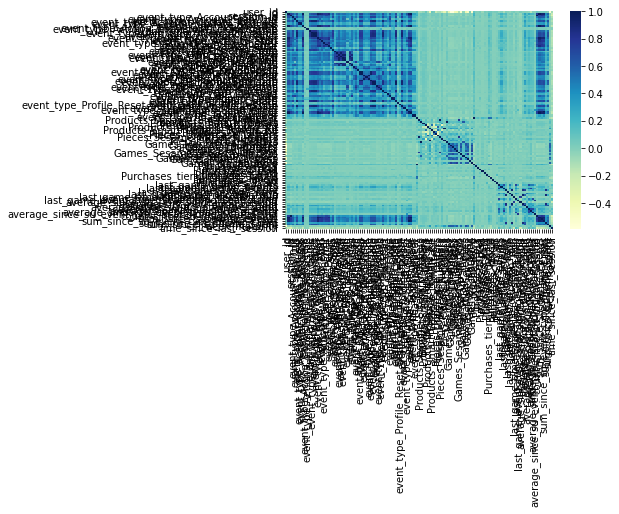

In [36]:
# Heatmap
corr = X.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu");


In [37]:
corr_df = corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head(20)


,feature_1,feature_2,correlation
7963,purchases_x,purchases_y,1.000000
8204,Products_Smart_Shapes,Pieces_Shapes,1.000000
9716,Pieces_Shapes,Products_Smart_Shapes,1.000000
11365,purchases_y,purchases_x,1.000000
15552,sum_since_su_event_type_Scene_Enter,event_type_Scene_Enter,0.999944
7488,event_type_Scene_Enter,sum_since_su_event_type_Scene_Enter,0.999944
373,session_id,count_since_su_unique_session,0.999791
15115,count_since_su_unique_session,session_id,0.999791
7681,event_type_Toast_Appear,event_type_Toast_Disappear,0.996808
7807,event_type_Toast_Disappear,event_type_Toast_Appear,0.996808


In [38]:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]



/tmp/ipykernel_1147/2710754905.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))


In [39]:
to_drop



['event_type_Account_Update_Success',
 'event_type_Action_Click',
 'event_type_Activation_New_Activation',
 'event_type_Activation_Piece',
 'event_type_Activation_Product',
 'event_type_Activity_Good_Answer',
 'event_type_Activity_Start',
 'event_type_OB_DiscoverTrial',
 'event_type_OB_DoYouHaveKit',
 'event_type_OB_Email',
 'event_type_OB_HasKitNo',
 'event_type_OB_HasKitYes',
 'event_type_OB_ProductHelp',
 'event_type_OB_ProductSeeMore',
 'event_type_OB_ProductSelection',
 'event_type_OB_ProfileBirthdate',
 'event_type_OB_ProfileName',
 'event_type_OB_Success',
 'event_type_Popup_Open',
 'event_type_Profile_Create',
 'event_type_Profile_Update',
 'event_type_Scene_Enter',
 'event_type_Scene_Leave',
 'event_type_Toast_Disappear',
 'Pieces_Sesame_Street_Numbers',
 'Pieces_Nordic_Letters',
 'Pieces_Shapes',
 'purchases_y',
 'average_since_su_duration_min',
 'count_since_su_unique_session',
 'sum_since_su_game_events',
 'sum_since_su_',
 'sum_since_su_event_type_Scene_Enter',
 'sum_since

In [40]:
X_uncorr = X.drop(columns = to_drop)
X_uncorr



,user_id,city,language,os_version,region,country,device_model,start_version,id,session_id,...,average_since_su_time_since_last_session,average_since_su_Time_Spent,average_since_su_good_answer_ratio,average_since_su_game_events,average_since_su_unique_activity,average_since_su_event_type_Scene_Enter,average_since_su_event_type_Scaffolding_Scaffolding,sum_since_su_Time_Spent,week_maturity,time_since_last_session
0,71853.0,Santiago,Spanish,14.8.1,Santiago Metropolitan,Chile,iPad Mini 4,1.3.0,478,30,...,194.436844,2315.866667,100.000000,15.933333,0.000000,5.833333,0.0,69476.0,8,7
1,71196.0,no_city,English,14.7.1,no_region,Qatar,iPad Pro,1.0.9,189,24,...,2123.642799,156.875000,0.000000,7.875000,0.000000,5.375000,0.0,3765.0,10,5
2,67336.0,Spruce Grove,English,14.8.1,Alberta,Canada,"iPad8,11",1.0.7,2384,44,...,1180.368281,15930.477273,46.974446,51.931818,4.590909,11.090909,0.0,700941.0,21,3
3,65692.0,Saint-Eustache,French,15.3.1,Quebec,Canada,iPad 5,1.0.1,148,36,...,1408.748717,220.885714,100.000000,3.028571,0.000000,1.771429,0.0,7731.0,26,7
4,71787.0,Ajax,English,15.4.1,Ontario,Canada,"iPad12,1",1.3.0,1090,41,...,1516.302586,1145.439024,99.316473,25.853659,0.292683,8.219512,0.0,46963.0,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2609,72422.0,Dubai,English,12.5.5,Dubai,United Arab Emirates,iPad Air,2.0.1,45,1,...,0.000000,3439.000000,0.000000,45.000000,0.000000,45.000000,0.0,3439.0,6,6
2610,27776.0,Falls Church,English,12.5.5,Virginia,United States,iPad Air,4.2.0,235,1,...,0.000000,5898.000000,100.000000,235.000000,33.000000,47.000000,49.0,5898.0,50,11
2611,72674.0,Talence,French,15.4.1,Gironde,France,"iPad8,11",2.0.4,96,1,...,0.000000,7478.000000,100.000000,376.000000,6.000000,55.000000,19.0,7478.0,4,4
2612,34309.0,Rye,English,14.8.1,New York,United States,iPad Mini 5,1.1.0,213,1,...,0.000000,9591.000000,100.000000,213.000000,4.000000,55.000000,0.0,9591.0,68,9


### Group columns by type (select_dtypes) to apply adequate preprocessing



In [41]:
class CustomMinMaxScale(MinMaxScaler):
    def fit(self, *args, **kwargs):
        return super().fit(*args, **kwargs) 
    
    def transform(self,*args, **kwargs):
        return pd.DataFrame(super().transform(*args, **kwargs), columns=self.get_feature_names_out())

    def fit_transform(self,*args, **kwargs):
        return pd.DataFrame(super().fit_transform(*args, **kwargs), columns=self.get_feature_names_out())
    

In [42]:
num_transformer = CustomMinMaxScale()
num_columns = X_uncorr.select_dtypes(include=['float64','int64','timedelta']).columns
num_columns


Index(['user_id', 'id', 'session_id', 'event_type_Account_Sign_In',
       'event_type_Account_Sign_Out', 'event_type_Account_Sign_Up',
       'event_type_Account_Update_Request',
       'event_type_Action_ConversionClickRedeem',
       'event_type_Action_ConversionClickSubscribe',
       'event_type_Activation_Game', 'event_type_Activity_Stop',
       'event_type_Activity_Wrong_Answer', 'event_type_Error_Error',
       'event_type_Game_Pause', 'event_type_Game_Start',
       'event_type_Game_Stop', 'event_type_OB_ClickStore',
       'event_type_OB_ClickTrial', 'event_type_OB_CommPreview',
       'event_type_OB_HasKeyNo', 'event_type_OB_KeyFail',
       'event_type_OB_KeyRedeem', 'event_type_OB_KeySuccess',
       'event_type_OB_ProductActivation', 'event_type_OB_ProductOther',
       'event_type_OB_ProductSK', 'event_type_OB_RenewalFail',
       'event_type_OB_RenewalSelection', 'event_type_OB_RenewalSuccess',
       'event_type_OB_TrialStart', 'event_type_OB_Type',
       'event_type

In [43]:
class CustomOHE(OneHotEncoder):
    def fit(self, *args, **kwargs):
        return super().fit(*args, **kwargs) 
    
    def transform(self,*args, **kwargs):
        return pd.DataFrame(super().transform(*args, **kwargs), columns=self.get_feature_names_out())

    def fit_transform(self,*args, **kwargs):
        return pd.DataFrame(super().fit_transform(*args, **kwargs), columns=self.get_feature_names_out())
    
    

In [44]:
cat_transformer = CustomOHE(sparse = False, handle_unknown = "ignore", drop='if_binary')
#sparse = False pour eviter que OHE qui renvoie trop de zero change le format de sortie apres le preprocessing

cat_columns = X_uncorr.select_dtypes(include=['object','O']).columns

cat_columns



Index(['city', 'language', 'os_version', 'region', 'country', 'device_model',
       'start_version', 'Type'],
      dtype='object')

In [45]:
bool_columns = X_uncorr.select_dtypes(include="bool").columns

bool_columns

Index([], dtype='object')

In [46]:
time_columns = X_uncorr.select_dtypes(include = ["datetime","datetime64[ns, UTC]"]).columns
time_columns



Index([], dtype='object')

In [47]:
len(cat_columns)+len(num_columns)+len(time_columns)+len(bool_columns)


101

### Define preprocessor


In [48]:
class CustomColumnTransformer(ColumnTransformer):
    
    def fit(self, *args, **kwargs):
        return super().fit(*args, **kwargs)
    
    def transform(self, X, *args, **kwargs):
        return pd.DataFrame(super().transform(X, *args, **kwargs), columns=self.get_feature_names_out())
    
    def fit_transform(self, X, *args, **kwargs):
        return pd.DataFrame(super().fit_transform(X, *args, **kwargs), columns=self.get_feature_names_out())


In [49]:
#pre-processor for all columns
preprocessor = CustomColumnTransformer([('num_tr',num_transformer,num_columns),('cat_tr',cat_transformer,cat_columns)],remainder = 'drop')



## Prepare preprocessed train & test data



In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_uncorr, y, test_size=0.30)


In [51]:
X_train.shape


(1829, 101)

In [52]:
X_preproc = pd.DataFrame(preprocessor.fit_transform(X_train))


In [53]:
preprocessor


CustomColumnTransformer(transformers=[('num_tr', CustomMinMaxScale(),
                                       Index(['user_id', 'id', 'session_id', 'event_type_Account_Sign_In',
       'event_type_Account_Sign_Out', 'event_type_Account_Sign_Up',
       'event_type_Account_Update_Request',
       'event_type_Action_ConversionClickRedeem',
       'event_type_Action_ConversionClickSubscribe',
       'event_type_Activation_Game', 'event_...
       'average_since_su_event_type_Scene_Enter',
       'average_since_su_event_type_Scaffolding_Scaffolding',
       'sum_since_su_Time_Spent', 'week_maturity', 'time_since_last_session'],
      dtype='object')),
                                      ('cat_tr',
                                       CustomOHE(drop='if_binary',
                                                 handle_unknown='ignore',
                                                 sparse=False),
                                       Index(['city', 'language', 'os_version', 'region', 'country', 'device_model',
       'start_version', 'Type'],
      dtype='object'))])

In [54]:
X_preproc

,num_tr__user_id,num_tr__id,num_tr__session_id,num_tr__event_type_Account_Sign_In,num_tr__event_type_Account_Sign_Out,num_tr__event_type_Account_Sign_Up,num_tr__event_type_Account_Update_Request,num_tr__event_type_Action_ConversionClickRedeem,num_tr__event_type_Action_ConversionClickSubscribe,num_tr__event_type_Activation_Game,...,cat_tr__start_version_5.2.1,cat_tr__start_version_5.2.2,cat_tr__start_version_5.2.3,cat_tr__start_version_7.22,cat_tr__start_version_8.0.0,cat_tr__start_version_8.1.0,cat_tr__start_version_9.1.0,cat_tr__start_version_9.1.1,cat_tr__start_version_9.1.3,cat_tr__Type_Teacher
0,0.953498,0.066405,0.088889,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.998794,0.009679,0.017778,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.990861,0.006233,0.017778,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.576124,0.004944,0.017778,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.928548,0.027928,0.146667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1824,0.918957,0.043091,0.106667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1825,0.983668,0.017620,0.031111,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1826,0.959787,0.004045,0.040000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1827,0.970583,0.001648,0.008889,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Feature selection


### permutation   #doesn't give interesting results




In [55]:
#Permet d'obtenir l'importance des features au regard des autres
#pour chaque modèle on l'entraine 10 fois en mélangeant les valeurs d'une colonne gardant toutes les autres identiques
 
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(max_iter = 500).fit(X_preproc, y_train) # Fit model




In [56]:
# on peut mettre un keyworld arg max_iter=1000, par défaut le modèle a une limite (100, à vérifier)
# permutation_score = permutation_importance(log_model, X_preproc, y_train, n_repeats=10) # Perform Permutation

# importance_df = pd.DataFrame(np.vstack((X_preproc.columns,
#                                         permutation_score.importances_mean)).T) # Unstack results
# importance_df.columns=['feature','score decrease']

# importance_df.sort_values(by="score decrease", ascending = False) # Order by importance


### Select percentile


In [57]:
class CustomSelectPercentile(SelectPercentile):
    def fit(self, *args, **kwargs):
        return super().fit(*args, **kwargs) 
    
    def transform(self,*args, **kwargs):
        return pd.DataFrame(super().transform(*args, **kwargs), columns=self.get_feature_names_out())

    def fit_transform(self,*args, **kwargs):
        return pd.DataFrame(super().fit_transform(*args, **kwargs), columns=self.get_feature_names_out())
    

# Define, optimize & train model


## Define model & optimize (grid search)


### Define full pipeline (with 75% select percentile)




In [58]:
pipe = make_pipeline(preprocessor,CustomSelectPercentile(percentile=75), RidgeClassifier())


In [59]:
pipe


Pipeline(steps=[('customcolumntransformer',
                 CustomColumnTransformer(transformers=[('num_tr',
                                                        CustomMinMaxScale(),
                                                        Index(['user_id', 'id', 'session_id', 'event_type_Account_Sign_In',
       'event_type_Account_Sign_Out', 'event_type_Account_Sign_Up',
       'event_type_Account_Update_Request',
       'event_type_Action_ConversionClickRedeem',
       'event_type_Action_ConversionClickSubs...
       'sum_since_su_Time_Spent', 'week_maturity', 'time_since_last_session'],
      dtype='object')),
                                                       ('cat_tr',
                                                        CustomOHE(drop='if_binary',
                                                                  handle_unknown='ignore',
                                                                  sparse=False),
                                                        Index(['city', 'language', 'os_version', 'region', 'country', 'device_model',
       'start_version', 'Type'],
      dtype='object'))])),
                ('customselectpercentile',
                 CustomSelectPercentile(percentile=75)),
                ('ridgeclassifier', RidgeClassifier())])

### Grid search



In [60]:
grid_search = GridSearchCV(
    pipe, 
    param_grid={
        'ridgeclassifier__solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
        'ridgeclassifier__alpha': [1,2,5],
        'ridgeclassifier__max_iter' : [1000]
    },
    cv=5,
    scoring="accuracy",
verbose=1, error_score='raise')


In [61]:
grid_search.fit(X_train, y_train)

grid_search.best_params_


Fitting 5 folds for each of 18 candidates, totalling 90 fits


/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWar

/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx

/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60 71] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 6] during transform. These unknown categories will be encoded 

/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 6] during transform. These unknown categories will be encoded 

/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWar

/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 3, 4, 5] during transform. These unknown categories will be encoded 

/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60 71] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx

/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, U

{'ridgeclassifier__alpha': 5,
 'ridgeclassifier__max_iter': 1000,
 'ridgeclassifier__solver': 'svd'}

In [62]:
grid_search.best_score_


0.9409476757242308

In [63]:
best_search = grid_search.best_estimator_



### Predict on X_test & confusion matrix


In [64]:
y_pred = best_search.predict(X_test)



/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [65]:
target_names = ['classe 0','Classe 1']
print(classification_report(y_test,y_pred,target_names=target_names))



              precision    recall  f1-score   support

    classe 0       0.91      0.97      0.94       313
    Classe 1       0.98      0.94      0.96       472

    accuracy                           0.95       785
   macro avg       0.95      0.95      0.95       785
weighted avg       0.95      0.95      0.95       785



In [66]:
cv_results_stacked = cross_validate(pipe, X_train, y_train, scoring='accuracy', cv=5)


/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWar

In [67]:
cv_results_stacked



{'fit_time': array([0.39886832, 0.28571343, 0.28907871, 0.2883594 , 0.27302337]),
 'score_time': array([0.11462975, 0.09783936, 0.10009336, 0.10537648, 0.10110712]),
 'test_score': array([0.93442623, 0.90710383, 0.92349727, 0.91803279, 0.91506849])}

In [68]:
best_search



Pipeline(steps=[('customcolumntransformer',
                 CustomColumnTransformer(transformers=[('num_tr',
                                                        CustomMinMaxScale(),
                                                        Index(['user_id', 'id', 'session_id', 'event_type_Account_Sign_In',
       'event_type_Account_Sign_Out', 'event_type_Account_Sign_Up',
       'event_type_Account_Update_Request',
       'event_type_Action_ConversionClickRedeem',
       'event_type_Action_ConversionClickSubs...
       'sum_since_su_Time_Spent', 'week_maturity', 'time_since_last_session'],
      dtype='object')),
                                                       ('cat_tr',
                                                        CustomOHE(drop='if_binary',
                                                                  handle_unknown='ignore',
                                                                  sparse=False),
                                                        Index(['city', 'language', 'os_version', 'region', 'country', 'device_model',
       'start_version', 'Type'],
      dtype='object'))])),
                ('customselectpercentile',
                 CustomSelectPercentile(percentile=75)),
                ('ridgeclassifier',
                 RidgeClassifier(alpha=5, max_iter=1000, solver='svd'))])

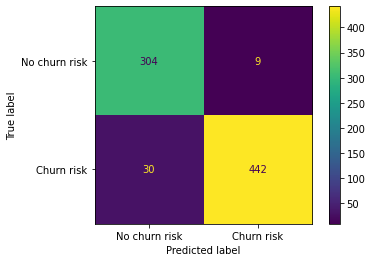

In [69]:
#Confusion matrix
label = ['No churn risk', 'Churn risk'] 
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=label)
disp.plot();

### Learning curves to test if we have enough data for a meaningful generalization


/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 6  7  8 16 22 26 33 34 39 60 62 63 64 65 66 67 70 71] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 7  8 22 33 34 60 62 63 64 65 67 7

/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 4  6  7  8 30 33 34 60 62 63 64 66 70 71] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 4  6  8 30 33 34 60 62 63 64 66 70 71] are co

/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 4  6  8 30 33 34 60 62 63 64 66 70 71] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 8 33 60 70 71] are constant.
  warnings.warn("Fe

/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 8 33 60 70 71] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [33 60 71] are constant.
  warnings.warn("Features %s are constant." % con

/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [33 60 71] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60 71] are constant.
  warnings.warn("Features %s are constant." % constant_fea

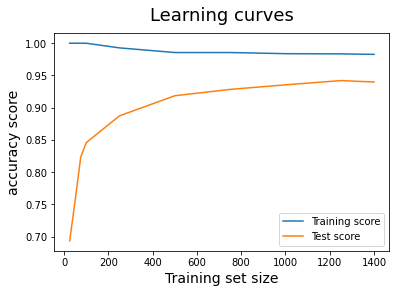

In [70]:
train_sizes= [25,50,75,100,250,500,750,1000,1250,1400]

train_sizes, train_scores, test_scores= learning_curve(
    estimator = best_search, X=X_train, y=y_train, train_sizes=train_sizes, cv=5)

# Take the mean of cross-validated train scores and validation scores
train_scores_mean= np.mean(train_scores, axis=1)
test_scores_mean= np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('accuracy score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()



### Test pipeline with a smaller select percentile : target is 3% of data points = 90 features







In [71]:
pipe_small = make_pipeline(preprocessor,CustomSelectPercentile(percentile=3), RidgeClassifier())

In [72]:
grid_search_small = GridSearchCV(
    pipe_small, 
    param_grid={
        'ridgeclassifier__solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
        'ridgeclassifier__alpha': [1,2,5],
        'ridgeclassifier__max_iter' : [1000]
    },
    cv=5,
    scoring="accuracy",
verbose=1, error_score='raise')


In [73]:
grid_search_small.fit(X_train, y_train)

grid_search_small.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWar

/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx

/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60 71] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, U

/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60 71] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx

/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, U

/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWar

/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx

/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60 71] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, U

/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 6] during transform. These unknown categories will be encoded 

{'ridgeclassifier__alpha': 2,
 'ridgeclassifier__max_iter': 1000,
 'ridgeclassifier__solver': 'svd'}

In [74]:
grid_search_small.best_score_



0.9611797290216334

In [75]:
best_search_small = grid_search_small.best_estimator_


In [76]:
y_pred_small = best_search_small.predict(X_test)



/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [77]:
print(classification_report(y_test,y_pred_small,target_names=target_names))


              precision    recall  f1-score   support

    classe 0       0.93      0.98      0.95       313
    Classe 1       0.99      0.95      0.97       472

    accuracy                           0.96       785
   macro avg       0.96      0.97      0.96       785
weighted avg       0.96      0.96      0.96       785



In [78]:
cv_results_stacked_small = cross_validate(pipe_small, X_train, y_train, scoring='accuracy', cv=5)
cv_results_stacked_small


/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWar

{'fit_time': array([0.13566995, 0.1596365 , 0.17113471, 0.1672864 , 0.1754477 ]),
 'score_time': array([0.08869195, 0.09050775, 0.08486414, 0.0894444 , 0.10126925]),
 'test_score': array([0.96994536, 0.96721311, 0.94262295, 0.96448087, 0.95342466])}

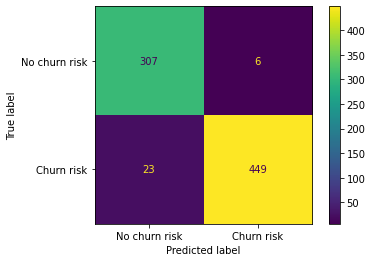

In [79]:
#Confusion matrix
label = ['No churn risk', 'Churn risk'] 
cm = confusion_matrix(y_test, y_pred_small)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=label)
disp.plot();

/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 6  7  8 16 22 26 33 34 39 60 62 63 64 65 66 67 70 71] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 7  8 22 33 34 60 62 63 64 65 67 7

/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 4  6  8 30 33 34 60 62 63 64 66 70 71] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6] during transform.

/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60 71] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2, 3, 4, 5, 6] during transform. These unknown categories will be encod

/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60 71] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60 71] are constant.
  warnings.warn("Features %s are constant." % constant_features_

/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/clementine/.pyenv/versions/3.8.12/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, U

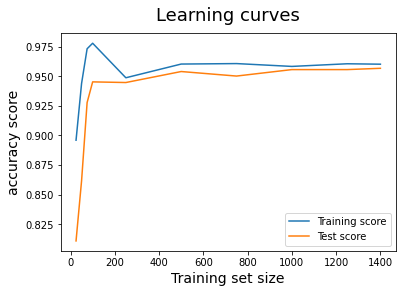

In [80]:
train_sizes= [25,50,75,100,250,500,750,1000,1250,1400]

train_sizes, train_scores, test_scores= learning_curve(
    estimator = best_search_small, X=X_train, y=y_train, train_sizes=train_sizes, cv=5)

# Take the mean of cross-validated train scores and validation scores
train_scores_mean= np.mean(train_scores, axis=1)
test_scores_mean= np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('accuracy score', fontsize = 14)

plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()



In [81]:
best_search_small.named_steps.keys()

dict_keys(['customcolumntransformer', 'customselectpercentile', 'ridgeclassifier'])

### Relative weight of features selected by the model (ANOVA)



In [82]:
#Analyse de la variance des colonnes gardées
pd.DataFrame(best_search_small.named_steps["customselectpercentile"].scores_,index=best_search_small.named_steps["customselectpercentile"].feature_names_in_).sort_values(by=0,ascending=False)[:33]

,0
num_tr__time_since_last_session,3904.530465
cat_tr__os_version_15.4.1,393.794831
num_tr__session_id,140.614268
cat_tr__start_version_2.0.5,124.684497
cat_tr__os_version_15.3.1,73.443192
num_tr__id,64.352852
num_tr__average_since_su_time_since_last_session,57.814671
num_tr__last_game_event_type_Scene_Enter,49.230413
num_tr__last_game_game_events,49.003663
cat_tr__start_version_2.0.4,48.477286


session_id : count unique de nombre de sessions observées par user   #id : count unique d'events observés par user



## Test accuracy by time_since_last_session



In [83]:
y_pred_df = pd.DataFrame(y_pred_small)
y_pred_df.rename(columns = {0:'churn_predict'}, inplace = True)
y_pred_df

,churn_predict
0,1.0
1,0.0
2,1.0
3,0.0
4,1.0
...,...
780,0.0
781,1.0
782,0.0
783,1.0


In [84]:
df_interm = pd.concat([X_test, pd.DataFrame(y_test)], axis = 1)
df_interm = df_interm.reset_index()


df_test = pd.concat([df_interm,y_pred_df], axis = 1)
df_test

,index,user_id,city,language,os_version,region,country,device_model,start_version,id,...,average_since_su_good_answer_ratio,average_since_su_game_events,average_since_su_unique_activity,average_since_su_event_type_Scene_Enter,average_since_su_event_type_Scaffolding_Scaffolding,sum_since_su_Time_Spent,week_maturity,time_since_last_session,churn_risk,churn_predict
0,394,72058.0,Pinsaguel,French,14.7.1,Upper Garonne,France,iPad 5,1.3.0,25,...,0.000000,12.500000,0.000000,4.500000,0.000000,471.0,7,7,1.0,1.0
1,1374,72222.0,Sacramento,English,14.6,California,United States,"iPad11,6",2.0.1,142,...,0.000000,23.666667,0.000000,2.500000,0.166667,6017.0,6,2,0.0,0.0
2,2513,68806.0,Spruce Grove,English,15.0.2,Alberta,Canada,iPad Air 2,1.0.8,105,...,100.000000,94.000000,5.000000,26.000000,0.000000,4299.0,18,8,1.0,1.0
3,142,32806.0,Edmond,English,15.4.1,Oklahoma,United States,iPad 6,1.0.3,3379,...,66.882311,94.714286,2.171429,25.514286,0.000000,135826.0,23,2,0.0,0.0
4,2446,67039.0,Indianapolis,English,14.8,Indiana,United States,"iPad11,6",1.0.6,187,...,50.000000,187.000000,10.000000,17.000000,0.000000,8958.0,21,5,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780,1578,72498.0,Bastia,French,15.3.1,Upper Corsica,France,"iPad12,1",2.0.3,655,...,50.000000,62.625000,0.500000,5.000000,0.250000,24452.0,5,1,0.0,0.0
781,2384,47449.0,Paris,French,14.8,Paris,France,iPad Mini 4,4.0.3,25,...,100.000000,25.000000,2.000000,13.000000,0.000000,697.0,78,10,1.0,1.0
782,44,72100.0,Toronto,English,15.3.1,Ontario,Canada,iPad Pro,1.3.0,1872,...,100.000000,66.040000,4.320000,11.640000,2.520000,136351.0,7,2,0.0,0.0
783,2435,71417.0,Blainville,French,14.8.1,Quebec,Canada,iPad 5,1.0.9,74,...,100.000000,74.000000,0.000000,17.000000,0.000000,1798.0,11,10,1.0,1.0


In [85]:
df_test["Evaluation_model"] = np.logical_not(np.logical_xor(df_test["churn_risk"],df_test["churn_predict"]))

df_test


,index,user_id,city,language,os_version,region,country,device_model,start_version,id,...,average_since_su_game_events,average_since_su_unique_activity,average_since_su_event_type_Scene_Enter,average_since_su_event_type_Scaffolding_Scaffolding,sum_since_su_Time_Spent,week_maturity,time_since_last_session,churn_risk,churn_predict,Evaluation_model
0,394,72058.0,Pinsaguel,French,14.7.1,Upper Garonne,France,iPad 5,1.3.0,25,...,12.500000,0.000000,4.500000,0.000000,471.0,7,7,1.0,1.0,True
1,1374,72222.0,Sacramento,English,14.6,California,United States,"iPad11,6",2.0.1,142,...,23.666667,0.000000,2.500000,0.166667,6017.0,6,2,0.0,0.0,True
2,2513,68806.0,Spruce Grove,English,15.0.2,Alberta,Canada,iPad Air 2,1.0.8,105,...,94.000000,5.000000,26.000000,0.000000,4299.0,18,8,1.0,1.0,True
3,142,32806.0,Edmond,English,15.4.1,Oklahoma,United States,iPad 6,1.0.3,3379,...,94.714286,2.171429,25.514286,0.000000,135826.0,23,2,0.0,0.0,True
4,2446,67039.0,Indianapolis,English,14.8,Indiana,United States,"iPad11,6",1.0.6,187,...,187.000000,10.000000,17.000000,0.000000,8958.0,21,5,1.0,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780,1578,72498.0,Bastia,French,15.3.1,Upper Corsica,France,"iPad12,1",2.0.3,655,...,62.625000,0.500000,5.000000,0.250000,24452.0,5,1,0.0,0.0,True
781,2384,47449.0,Paris,French,14.8,Paris,France,iPad Mini 4,4.0.3,25,...,25.000000,2.000000,13.000000,0.000000,697.0,78,10,1.0,1.0,True
782,44,72100.0,Toronto,English,15.3.1,Ontario,Canada,iPad Pro,1.3.0,1872,...,66.040000,4.320000,11.640000,2.520000,136351.0,7,2,0.0,0.0,True
783,2435,71417.0,Blainville,French,14.8.1,Quebec,Canada,iPad 5,1.0.9,74,...,74.000000,0.000000,17.000000,0.000000,1798.0,11,10,1.0,1.0,True


In [86]:
print(list(df_test.columns))



['index', 'user_id', 'city', 'language', 'os_version', 'region', 'country', 'device_model', 'start_version', 'id', 'session_id', 'event_type_Account_Sign_In', 'event_type_Account_Sign_Out', 'event_type_Account_Sign_Up', 'event_type_Account_Update_Request', 'event_type_Action_ConversionClickRedeem', 'event_type_Action_ConversionClickSubscribe', 'event_type_Activation_Game', 'event_type_Activity_Stop', 'event_type_Activity_Wrong_Answer', 'event_type_Error_Error', 'event_type_Game_Pause', 'event_type_Game_Start', 'event_type_Game_Stop', 'event_type_OB_ClickStore', 'event_type_OB_ClickTrial', 'event_type_OB_CommPreview', 'event_type_OB_HasKeyNo', 'event_type_OB_KeyFail', 'event_type_OB_KeyRedeem', 'event_type_OB_KeySuccess', 'event_type_OB_ProductActivation', 'event_type_OB_ProductOther', 'event_type_OB_ProductSK', 'event_type_OB_RenewalFail', 'event_type_OB_RenewalSelection', 'event_type_OB_RenewalSuccess', 'event_type_OB_TrialStart', 'event_type_OB_Type', 'event_type_OB_VerifCode', 'even

In [87]:
mappingdict = {True: 1, False: 0}
df_test["Evaluation_model"] =df_test["Evaluation_model"].map(mappingdict)



(array([ 29.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 756.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

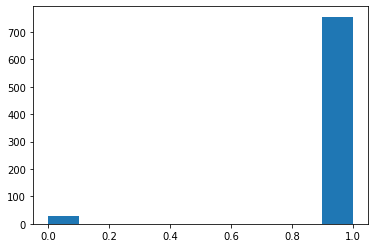

In [88]:
plt.hist(df_test["Evaluation_model"])

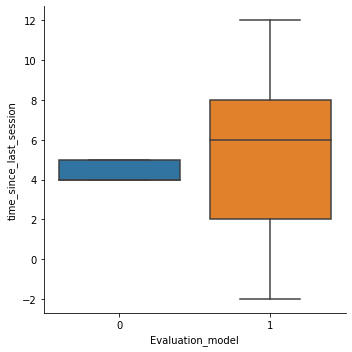

In [89]:
sns.catplot(x='Evaluation_model', y='time_since_last_session', data=df_test, kind = 'box')



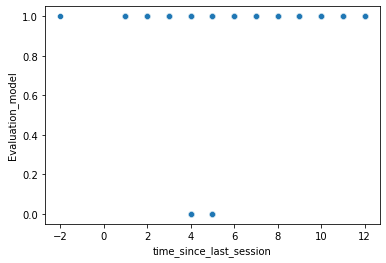

In [90]:
sns.scatterplot(x="time_since_last_session", y="Evaluation_model", data=df_test);



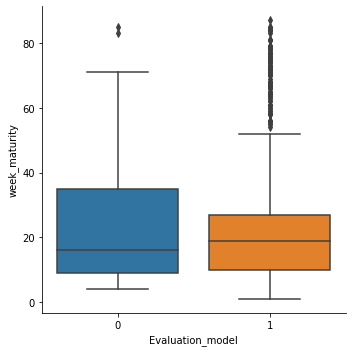

In [91]:
sns.catplot(x='Evaluation_model', y='week_maturity', data=df_test, kind = 'box')



In [94]:
errors = df_test[df_test["Evaluation_model"] == 0]




(array([19.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10.]),
 array([4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ]),
 <BarContainer object of 10 artists>)

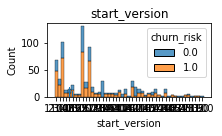

In [95]:
plt.figure(figsize=(10,3))     

# # First subplot
plt.subplot(2,3,1)  #nb de lignes, nb de colonnes, position
sns.histplot(data=df_test, x=df_test["start_version"], hue="churn_risk", multiple="stack")
plt.title('start_version')
# plt.legend()

# # Second subplot
plt.subplot(2,3,1)  #en position 2
plt.hist(errors["time_since_last_session"])
# plt.title("all energies")


(array([  1.,   0., 197.,  61.,  68., 154.,  66., 116.,  65.,  57.]),
 array([-2. , -0.6,  0.8,  2.2,  3.6,  5. ,  6.4,  7.8,  9.2, 10.6, 12. ]),
 <BarContainer object of 10 artists>)

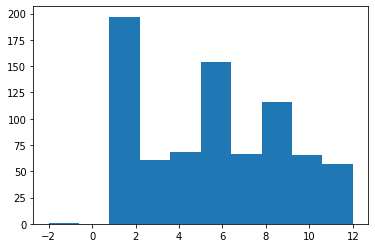

In [96]:
plt.hist(df_test["time_since_last_session"])



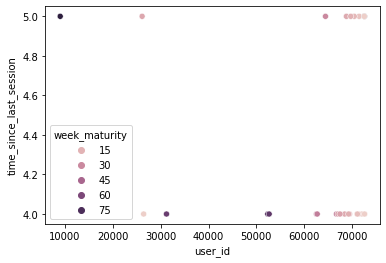

In [97]:
sns.scatterplot(x="user_id", y="time_since_last_session", hue='week_maturity', data=errors);


(array([19.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10.]),
 array([4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ]),
 <BarContainer object of 10 artists>)

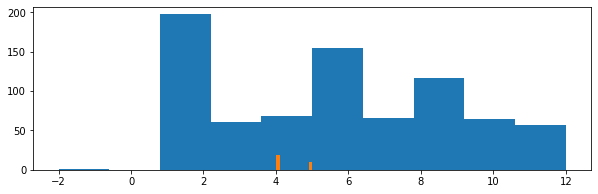

In [99]:
plt.figure(figsize=(10,3))     

# # First subplot
# plt.subplot(1,2,1)  #nb de lignes, nb de colonnes, position
plt.hist(df_test["time_since_last_session"])
# plt.plot(years_x, gas_y, label = "gas")
# plt.title('coal vs. gas')
# plt.legend()

# # Second subplot
# plt.subplot(1,2,2)  #en position 2
plt.hist(errors["time_since_last_session"])
# plt.title("all energies")
